# Scraping MTGStocks for Magic: The Gathering Card Prices

## Import Libraries

In [1]:
import pandas as pd 
import glob 
from bs4 import BeautifulSoup 
import requests 
import datetime 
import time 
import json 
import csv
import matplotlib.pyplot as plt 

## Downloading HTM files from MTGStocks.com and retrieving the link of every Final Fantasy Card and storing it into a dictionary.
### In order to retrieve the link of 600+ individual cards from the Universes Beyond: Final Fantasy set, I had to manually download all thirteen pages <a href="https://www.mtgstocks.com/sets/2197-universes-beyond-final-fantasy">from the MTGStocks Universes Beyond: Final Fantasy landing page.</a>
<img src="https://tcgplayer-cdn.tcgplayer.com/product/630959_in_1000x1000.jpg">

In [2]:
paths = glob.glob("../data/mtgcards/*.htm") # Store all of the file paths into the variable "paths"
paths

['../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 09.htm',
 '../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 08.htm',
 '../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 11.htm',
 '../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 05.htm',
 '../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 04.htm',
 '../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 10.htm',
 '../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 06.htm',
 '../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 12.htm',
 '../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 13.htm',
 '../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 07.htm',
 '../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 03.htm',
 '../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 02.htm',
 '../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card 

### Parsing through each file using for loops and storing the card name and link into a list of dictionaries.

In [3]:
card_links = [] # Create an empty list. This is where the list of dictionaries.
for path in paths: # Use a for loop to read .htm files stored in the "paths" variable.
    print(f"Processing {path}...") # Track the processing of each HTM files.
    with open(path, "r") as page:
        soup = BeautifulSoup(page, "html.parser")
        
for path in paths: # Loop through all HTM file paths.
    with open(path, "r") as page: # Open each HTM file.
            soup = BeautifulSoup(page, "html.parser") # Parse the HTM file using BeautifulSoup.
            for table in soup.find_all("table"): # Use the find_all function to locate the table where our data is hiding.
                for a in table.find_all("a", href=True): # Find all <a> tags that have an href attribute.
                    href = a["href"] # Extract the link from the 'href' attribute.
                    text = a.get_text(strip=True) # Extract text from the link, removing leading/trailing spaces.
                    card_links.append({ # Store both the name and the link in a dictionary.
                        "card_name": text, # The card name.
                        "card_link": href # The card link.
                    })

Processing ../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 09.htm...
Processing ../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 08.htm...
Processing ../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 11.htm...
Processing ../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 05.htm...
Processing ../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 04.htm...
Processing ../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 10.htm...
Processing ../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 06.htm...
Processing ../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 12.htm...
Processing ../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 13.htm...
Processing ../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 07.htm...
Processing ../data/mtgcards/Universes Beyond_ Final Fantasy (FIN) • Card List 03.htm...
Processing ../data/mtgcards/Univ

In [4]:
# card_links # Call the variable to make sure it looks right

### Separating the card id from the link

In [5]:
card_ids = [] # Create an empty list to store the ids of every card
card_ids = [link["card_link"].split("/prints/")[1].split("-")[0] for link in card_links]
# card_ids # Call list to make sure everything looks good.

# Finally, create a list of links using every cards unique id to gain access their price history via the MTGStocks API json dictionaries.

In [6]:
card_api_links = [] # Create an empty list of links for the api.
for card_id in card_ids: # Loop through the list of card ids.
    link = f"https://api.mtgstocks.com/prints/{card_id}/prices/tcgplayer" # Attatch code to the api link.
    card_api_links.append(link) # Store each link into the card_api_links list.

In [7]:
# card_api_links # Call card_api_links to make sure everything looks good.

### Make sure there is an equal amount of ids and links

In [8]:
len(card_api_links) # Returns the length of the card_api_links list

644

In [9]:
len(card_ids) #Returns the length of the card_ids list

644

### Using pandas to create a dataframe from the api links

In [10]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
}

test_url = "https://api.mtgstocks.com/prints/127325/prices/tcgplayer"

response = requests.get(test_url, headers = headers)
ff_card_data = response.json()

if isinstance(ff_card_data, dict):
    # if there's a "data" or similar key that holds the prices
    for key in ['data', 'prices', 'values', 'tcgplayer']:
        if key in ff_card_data:
            ff_card_data = ff_card_data[key]
            break

# Ensure it's a list of records before making a DataFrame
if isinstance(ff_card_data, list):
    ff_df = pd.json_normalize(ff_card_data)
else:
    ff_df = pd.DataFrame([ff_card_data])

### Creating a new dataframe for each of the price points 'low', 'avg', foil', 'market', and 'market_foil'
### Merge all of the dataframes into a single dataframe on 'timestamp'

In [11]:
ff_df_low = pd.DataFrame(ff_card_data["low"], columns=["timestamp", "low"])
ff_df_avg = pd.DataFrame(ff_card_data["avg"], columns=["timestamp", "avg"])
ff_df_foil = pd.DataFrame(ff_card_data["foil"], columns=["timestamp", "foil"])
ff_df_market = pd.DataFrame(ff_card_data["market"], columns=["timestamp", "market"])
ff_df_market_foil = pd.DataFrame(ff_card_data["market_foil"], columns=["timestamp", "market_foil"])

ff_merged_df = ff_df_low.merge(ff_df_avg, on="timestamp").merge(ff_df_foil, on="timestamp").merge(ff_df_market, on="timestamp").merge(ff_df_market_foil)

In [12]:
ff_merged_df # Return the dataframe to make sure everything looks good.

,timestamp,low,avg,foil,market,market_foil
0,1748563200000,183.64,183.64,262.18,164.37,235.00
1,1748649600000,199.99,199.99,261.10,166.23,242.88
2,1748736000000,195.99,197.99,250.18,166.23,242.88
3,1748822400000,142.63,145.80,276.40,164.52,243.17
4,1748908800000,143.80,145.30,272.76,162.38,243.17
...,...,...,...,...,...,...
150,1761523200000,65.78,79.85,191.95,70.18,165.36
151,1761609600000,65.78,77.87,189.99,70.19,165.36
152,1761696000000,62.79,77.67,187.73,68.46,165.36
153,1761782400000,61.41,77.59,187.80,68.46,165.35


### Converting Epoch time to datetime (seriously, why are we using epoch time in the big 25?)

In [13]:
ff_merged_df["date"] = pd.to_datetime(ff_merged_df["timestamp"], unit="ms") # Create a new column in the dataframe that converts epoch time to datetime.

In [14]:
ff_new_df = ff_merged_df.drop("timestamp", axis=1) # Create a new data frame that removes the 'timestamp' column from the merged dataframe 
ff_new_df

,low,avg,foil,market,market_foil,date
0,183.64,183.64,262.18,164.37,235.00,2025-05-30
1,199.99,199.99,261.10,166.23,242.88,2025-05-31
2,195.99,197.99,250.18,166.23,242.88,2025-06-01
3,142.63,145.80,276.40,164.52,243.17,2025-06-02
4,143.80,145.30,272.76,162.38,243.17,2025-06-03
...,...,...,...,...,...,...
150,65.78,79.85,191.95,70.18,165.36,2025-10-27
151,65.78,77.87,189.99,70.19,165.36,2025-10-28
152,62.79,77.67,187.73,68.46,165.36,2025-10-29
153,61.41,77.59,187.80,68.46,165.35,2025-10-30


<img src="https://raw.githubusercontent.com/brandonmalave/imagehost/refs/heads/main/sepiroth%2C%20fabled%20soldier.jpg?token=GHSAT0AAAAAADOKU7YSNQW2Y523HQZ77A4U2IFMNFQ">

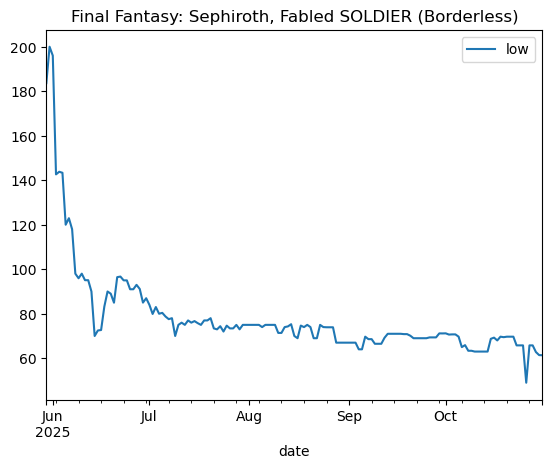

In [15]:
ff_new_df.plot(x='date', y='low', kind='line', title='Final Fantasy: Sephiroth, Fabled SOLDIER (Borderless)')
plt.show()

### Instead of repeating this process with the Ixal Standard Set, I will compare the most expensive card in this set to the most expensive card of the Final Fantasy set.

In [16]:
test_url = "https://api.mtgstocks.com/prints/35596/prices/tcgplayer"

response = requests.get(test_url, headers = headers)
ixalan_card_data = response.json()

if isinstance(ixalan_card_data, dict):
    # if there's a "data" or similar key that holds the prices
    for key in ['data', 'prices', 'values', 'tcgplayer']:
        if key in ixalan_card_data:
            ixalan_card_data = ixalan_card_data[key]
            break

# Ensure it's a list of records before making a DataFrame
if isinstance(ixalan_card_data, list):
    ixalan_df = pd.json_normalize(ixalan_card_data)
else:
    ixalan_df = pd.DataFrame([ixalan_card_data])

<img src="https://raw.githubusercontent.com/brandonmalave/imagehost/refs/heads/main/revel%20in%20riches.jpg?token=GHSAT0AAAAAADOKU7YS5Q2TVM6AC4QAGAXA2IFMQUQ">

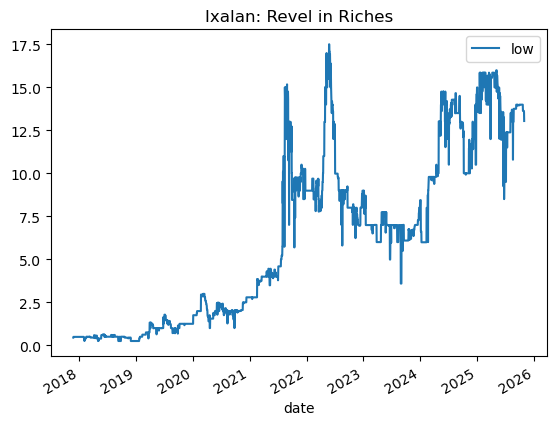

In [17]:
ixalan_df_low = pd.DataFrame(ixalan_card_data["low"], columns=["timestamp", "low"])
ixalan_df_avg = pd.DataFrame(ixalan_card_data["avg"], columns=["timestamp", "avg"])
ixalan_df_foil = pd.DataFrame(ixalan_card_data["foil"], columns=["timestamp", "foil"])
ixalan_df_market = pd.DataFrame(ixalan_card_data["market"], columns=["timestamp", "market"])
ixalan_df_market_foil = pd.DataFrame(ixalan_card_data["market_foil"], columns=["timestamp", "market_foil"])

ixalan_merged_df = ixalan_df_low.merge(ixalan_df_avg, on="timestamp").merge(ixalan_df_foil, on="timestamp").merge(ixalan_df_market, on="timestamp").merge(ixalan_df_market_foil)

ixalan_merged_df["date"] = pd.to_datetime(ixalan_merged_df["timestamp"], unit="ms")

ixalan_new_df = ixalan_merged_df.drop("timestamp", axis=1)

ixalan_new_df.plot(x='date', y='low', kind='line', title='Ixalan: Revel in Riches')
plt.show()

### Closing Notes
- The next step in this data investigation would be to automate this process, prehaps by creating a function where I could just input a card id and it will return a dataframe and line graph, properly labled by card name.
- Off the top of my head, this can be done a couple ways. Using a for loop to make a dictionary that includes each of the 644 unique card links in the card_api_links list, and all of the relevant data obtained by parseing the json.
### ChatGPT Disclaimer
- I used ChatGPT to troubleshoot some errors, like when I used the 'if isinstance' function when parsing through the api links. As far as I remember, we were not taught this in class, so I am not sure what this function actually does, but the fix provided got me through a hiccup I was encountering. Before I was returning an error "ValueError: All arrays must be of the same length," when I stored the response.json() into a dataframe. I was not sure how to fix it and resorted to chatGPT.
### Further Data Analysis
- Some things to consider: Is it possible to use the complete list of cards per set to chart a general price trend across all cards all at once? Do this with the Ixalan Standard set and compare the two if possible
- Excluding market foils and foils because those are more of a premium product for collectors, and holds no real value to the average joe playing the game and buying cards requried to complete their decks.
- Creating a csv that is a complete database of every single card I used in this analysis.